# Coursework: Hydraulic model calibration


### CIVE 70019/70057
Department of Civil and Environmental Engineering, Imperial College London

You have been tasked with the evaluation and calibration of the hydraulic model of EXNING, a district metered area (DMA) in Anglian Water's (AW) water distribution network. To achieve this, you have been provided:
* a recently calibrated hydraulic model of the EXNING DMA (2019),
* loading conditions (demands, reservoir heads) and head measurements covering a period of 4 days.

The objective of the coursework is to prepare a short calibration report for AW by completing the tasks below and answering the questions based on your results.

You have been provided the following information about EXNING:
* EXNING is part of a larger system of cascading DMAs: EXNING is fed by the NEWSEV DMA and feeds into the BURWEL DMA.
* The "reservoir" head and total demand of EXNING are derived from flow and pressure sensors at the DMA inlet (& outlet).
* Node elevations have been updated in the provided model following a GPS survey of sensor locations.

In [1]:
import sys
import os
import numpy as np
from numpy import linalg as la
import networkx as nx
import pandas as pd
import wntr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import copy
from datetime import datetime, timedelta
import cvxpy as cp
## TODO
import warnings
warnings.filterwarnings('ignore')

# improve matplotlib image quality
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

### Load network properties and operational data

Load functions created in previous assignments.

In [ ]:
# load functions from src folder
sys.path.append('../src/')
from general_functions import *
from hydraulic_functions import *

Load network .inp file and operational data from the module repository's data directory.

In [4]:
data_dir = '../data/parameter_estimation/'
net_dir = '../data/networks/'

net_name = 'exning.inp'
data_name = 'exning_coursework_dataset.npy'

# load operational data
data = np.load(os.path.join(data_dir, data_name), allow_pickle=True).item()
h_data = data['h_data']
sensor_idx = data['sensor_idx'] - 1 # matlab to python index offset
d_data = data['d']
h0_data = data['h0'].reshape(-1, 1).T

# load network properties
wdn = load_network_data(os.path.join(net_dir, net_name))
A12 = wdn.A12
A10 = wdn.A10
net_info = wdn.net_info
link_df = wdn.link_df
node_df = wdn.node_df
demand_df = wdn.demand_df

Plot sensor nodes in network. We provide a plotting function below.

In [5]:
#### DO NOT CHANGE THIS ####
# define plotting function using networkx
def plot_network(wdn, sensor_idx, vals=None, highlight_valves=None):

    # create figure and axis
    fig, ax = plt.subplots(figsize=(10, 7))

    # unload data
    link_df = wdn.link_df
    node_df = wdn.node_df
    net_info = wdn.net_info

    # draw network
    uG = nx.from_pandas_edgelist(link_df, source='node_out', target='node_in')
    pos = {row['node_ID']: (row['xcoord'], row['ycoord']) for _, row in node_df.iterrows()}
    nx.draw(uG, pos, ax=ax, node_size=20, node_shape='o')

    # draw reservoir
    nx.draw_networkx_nodes(
        uG, pos, nodelist=net_info['reservoir_names'],
        node_size=100, node_shape='s', node_color='black', ax=ax
    )

    # draw sensor nodes
    sensor_names = [net_info['junction_names'][i] for i in sensor_idx]
    nx.draw_networkx_nodes(
        uG, pos, nodelist=sensor_names, node_size=100,
        node_shape='o', node_color='red', edgecolors='white', ax=ax
    )

    # reservoir labels
    reservoir_labels = {node: 'Reservoir' for node in net_info['reservoir_names']}
    labels_res = nx.draw_networkx_labels(uG, pos, reservoir_labels, font_size=12, ax=ax)
    for _, label in labels_res.items():
        label.set_y(label.get_position()[1] + 1750)

    # sensor labels
    sensor_labels = {node: str(idx+1) for (idx, node) in enumerate(sensor_names)}
    labels_sen = nx.draw_networkx_labels(uG, pos, sensor_labels, font_size=12, ax=ax)
    for _, label in labels_sen.items():
        label.set_y(label.get_position()[1] + 1750)

    # plot sensor values if provided
    if vals is not None:
        cmap = cm.get_cmap('RdYlGn_r')
        nx.draw_networkx_nodes(
            uG, pos, nodelist=sensor_names, node_size=100,
            node_shape='o', node_color=vals, cmap=cmap, edgecolors='white', ax=ax
        )

        # create color bar
        sm = plt.cm.ScalarMappable(cmap=cmap)
        sm.set_array(vals)
        colorbar = plt.colorbar(sm, ax=ax)
        colorbar.set_label('Mean pressure residual [m]', fontsize=12)

    # highlight link
    if highlight_valves is not None:
        nx.draw_networkx_nodes(uG, pos, highlight_valves, node_size=200, node_shape='d', node_color='limegreen', edgecolors='white')

    # display plot
    plt.show()

Visualise the EXNING network graph and highlight information relevant to the evaluation of the hydraulic model.

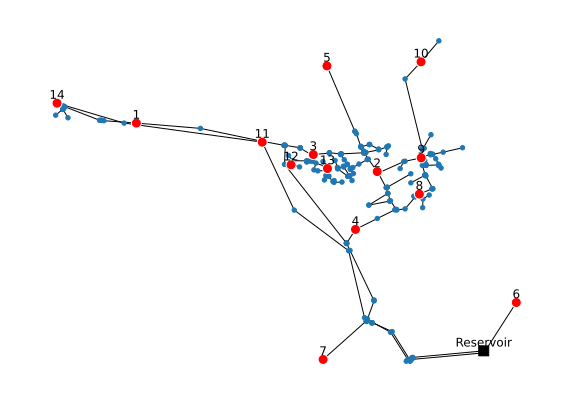

In [7]:
plot_network(wdn, sensor_idx)

Simulate initial (uncalibrated) network hydraulics over 4 days. We first define a function to solve network hydraulics using the `wntr` package, which we used previously in the hyraulic modelling notebook. The following tasks are performed in this function:
- Load network properties
- Modify simulation time to match operational data
- Assign h0 data at model reservoir
- Scale and apply new demand pattern from inflow data
- Option to modify pipe roughness (or HW) coefficients

<font color="blue">NB: this is done for you below. Provided the correct inputs, you do not need to replicate this function.

In [9]:
#### DO NOT CHANGE THIS ####
# hydraulic solver function
def hydraulic_solver(inp_file, d_data, h0_data, C=None, demand=False):

    # load network from wntr
    inp_file = os.path.join(net_dir, net_name)
    wn = wntr.network.WaterNetworkModel(inp_file)

    # get network properties
    reservoir_names = wn.reservoir_name_list
    junction_names = wn.junction_name_list
    link_names = wn.link_name_list

    # modify simulation time and hydraulic time step
    nt = h0_data.shape[1]
    wn.options.time.duration = (nt - 1) * 3600
    wn.options.time.hydraulic_timestep = 3600
    wn.options.time.pattern_timestep = 3600
    wn.options.time.report_timestep = 3600

    # assign reservoir data
    for (i, name) in enumerate(reservoir_names):
        wn.add_pattern(f'h0_{i}', h0_data[i])
        reservoir = wn.get_node(name)
        reservoir.head_timeseries.base_value = 1
        reservoir.head_timeseries.pattern_name = wn.get_pattern(f'h0_{i}')

    # replace demand data
    for idx, name in enumerate(junction_names):

        if any(val != 0 for val in d_data[idx, :]):
            node = wn.get_node(name)
            d_pat = d_data[idx, :]
            wn.add_pattern('d_'+name, d_pat)

            for (i, num) in enumerate(node.demand_timeseries_list):
                if i == 0:
                    node.demand_timeseries_list[i].base_value = 1
                    node.demand_timeseries_list[i].pattern_name = 'd_'+name
                else:
                    node.demand_timeseries_list[i].base_value = None
                    node.demand_timeseries_list[i].pattern_name = None

    # assign roughness (or HW) coefficients
    if C is not None:
        for name, link in wn.links():

            # check if the link is a pipe
            if isinstance(link, wntr.network.Pipe):
                link.roughness = C[link_names.index(name)]

            # check if link is a valve
            elif isinstance(link, wntr.network.Valve):
                link.minor_loss = C[link_names.index(name)]
                link.initial_setting = C[link_names.index(name)]

    # run simulation and get results
    sim = wntr.sim.EpanetSimulator(wn)
    results = sim.run_sim()

    q_sim = results.link['flowrate'].T
    h_sim = results.node['head'].T
    h_sim = h_sim[~h_sim.index.isin(reservoir_names)] # delete reservoir nodes
    d = results.node['demand'].T
    d = d[~d.index.isin(reservoir_names)] # delete reservoir nodes


    if demand == True:
        return d.to_numpy()
    else:
        return q_sim.to_numpy(), h_sim.to_numpy()

### Part 0: Preliminary evaluation

Run simulation with initial $C_0$ values.

In [10]:
C_0 = link_df['C'].to_numpy()
# Supplants the network model with the available data (loading conditions, head measurements).
q_sim, h_sim = hydraulic_solver("", d_data, h0_data, C_0)

Compare simulated heads at sensor nodes (node indices in `sensor_idx`) with the simulated heads over the 4-day period. Visualise the results with, e.g. a boxplot of pressure residuals on the test dataset.

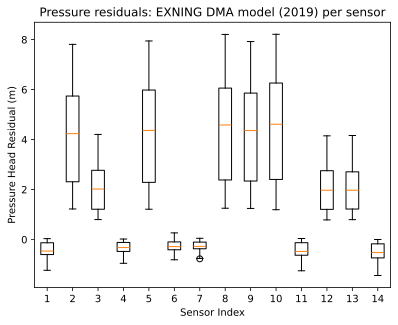

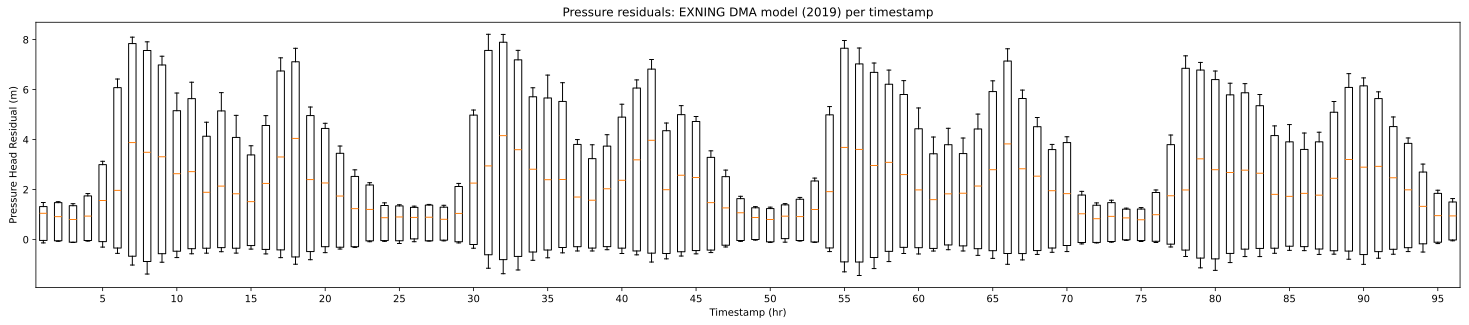

In [ ]:
# from Lecture 3 - Assignment Review: `Pressure residual = simulated - measured``

sensor_idx_residuals = np.zeros(h_data.shape)
for (data_idx, sim_idx) in enumerate(sensor_idx):
    sensor_idx_residual = np.array(h_sim[sim_idx] - h_data[data_idx])
    # sensor_idx_residuals.append(sensor_idx_residual)
    sensor_idx_residuals[data_idx] = sensor_idx_residual

plt.boxplot(sensor_idx_residuals.tolist())
plt.xlabel("Sensor Index")
plt.ylabel("Pressure Head Residual (m)")
plt.title("Pressure residuals: EXNING DMA model (2019) per sensor")
plt.show()

timestamp_residuals = sensor_idx_residuals.T

# Widened figure size and filtered timestamps help readibility.
default_figsize = plt.rcParams['figure.figsize']
widened_figsize = [default_figsize[0]*4, default_figsize[1]]
plt.subplots(figsize = widened_figsize)
plt.boxplot(timestamp_residuals.tolist())
plt.xlabel("Timestamp (hr)")

ticks, labels = plt.xticks()
filtered_labels = []
filtered_ticks = []
for i in range(0, ticks.size):
    # Timestamps are 1-indexed.
    if i % 5 == 4:
        filtered_labels.append(labels[i])
        filtered_ticks.append(ticks[i])
plt.xticks(filtered_ticks, filtered_labels)

plt.ylabel("Pressure Head Residual (m)")
plt.title("Pressure residuals: EXNING DMA model (2019) per timestamp")

plt.show()

**<u>Question 1:</u>** Is the current hydraulic model of EXNING accurate according to hydraulic model calibration guidelines? Comment on the results of the preliminary model evaluation and, in particular, on
* the **sign** (i.e. are heads over or underestimated in the hydraulic simulation?) of pressure/head residuals,
* the **temporal** distribution (i.e. are the residuals time/flow dependent?) of pressure/head residuals,
* and the **spatial** distribution (i.e. are all sensors affected?) of the pressure/head residuals.

Given the information you were provided about the EXNING system and the results of the preliminary model evaluation, identify the most likely sources of model errors.

- For indexes 1,4,6,7,11,14 the heads are slightly underestimated by the sim. For indexes 2,3,5,8,,9,10,12,13 they are overestimated.
It looks like 12,3, 13 have moderate head loss and 5,2,10,8,9 are huge; which is spatial. i should load it up on EPANet to confirm.


### Part 1: Hydraulic model calibration (without regularisation)

Following initial reports concerning discrepancies in the recently calibrated EXNING model, AW were able to confirm that:
- flow and head sensors had been calibrated before collection of load/field data corresponding to the train and test datasets,
- demands in the train and test dataset are accurate (incl. for large users).

As a result, the remaining deviations between measured and simulated pressures must result from inaccurate model parameters. Errors associated with unknown valve status (for instance, unregistered closed valves) can be identified by solving a model calibration problem where pipe roughness coefficients are known, but valve minor/local loss coefficients are free to vary. In part 1, you will solve a hydraulic model calibration problem without regularisation. Complete the code below to calibrate the network model using the head measurements provided in data.

#### Split the data into *train* and *test* datasets.
We suggest using the first day worth of data as a <u>train dataset</u> and the remaining 3 days as a <u>test dataset</u>.

In [ ]:
# tain data
nt_train = 24
data_train = {
    'd': d_data[:, :nt_train],
    'h0': h0_data[:, :nt_train],
    'h_data': h_data[:, :nt_train]
}

# test data
data_test = {
    'd': d_data[:, nt_train:],
    'h0': h0_data[:, nt_train:],
    'h_data': h_data[:, nt_train:]
}

**<u>Question 2:</u>** Briefly comment on the definition of the train data set. What impact will it have on the generalizability of your model? (i.e., what range of conditions will you confidently be able to use your model for?)

#### Definition of the loss function.

In [ ]:
def loss_fun(h, h_data):
    return ( 1/len(h_data.flatten()) ) * np.sum( ( h[sensor_idx, :] - h_data )**2 )

**<u>Question 3:</u>** Justify the choice/definition of the loss function, loss_fun.

#### Solve the parameter estimation problem using the train dataset
We first solve the hydraulic model calibration problem without regularisation. (You can reuse and adapt the code provided in Week 6.)

The following function is needed for the sequential convex programming (SCP) method used in this coursework. As with the `hydraulic_solver` function, we provide the following code in `linear_approx_calibration` for you to use throughout this notebook.

In [ ]:
#### DO NOT CHANGE THIS ####
# compute matrices for the head loss linear approximation of the HW headloss
def linear_approx_calibration(wdn, q, C):
    # unload data
    A12 = wdn.A12
    A10 = wdn.A10
    net_info = wdn.net_info
    link_df = wdn.link_df

    K = np.zeros((net_info['np'], 1))
    n_exp = link_df['n_exp'].astype(float).to_numpy().reshape(-1, 1)
    b1_k = copy.copy(K)
    b2_k = copy.copy(K)

    for idx, row in link_df.iterrows():
        if row['link_type'] == 'pipe':
            K[idx] = 10.67 * row['length'] * (C[idx] ** -row['n_exp']) * (row['diameter'] ** -4.8704)
            b1_k[idx] = copy.copy(K[idx])
            b2_k[idx] = (-n_exp[idx] * K[idx]) / C[idx]

        elif row['link_type'] == 'valve':
            K[idx] = (8 / (np.pi ** 2 * 9.81)) * (row['diameter'] ** -4) * C[idx]
            b1_k[idx] = -n_exp[idx] * copy.copy(K[idx])
            b2_k[idx] = copy.copy(K[idx]) / C[idx]

    a11_k = np.tile(K, q.shape[1]) * np.abs(q) ** (n_exp - 1)
    b1_k = np.tile(b1_k, q.shape[1]) * np.abs(q) ** (n_exp - 1)
    b2_k = np.tile(b2_k, q.shape[1]) * np.abs(q) ** (n_exp - 1) * q

    return a11_k, b1_k, b2_k

SCP implementation

In [ ]:
# unload network training data
n_exp = link_df['n_exp']
d = data_train['d']
h_data = data_train['h_data']
h0 = data_train['h0'].reshape(-1, 1).T

# define SCP problem parameters
Ki = np.inf
iter_max = 50
delta_k = 20
C_up_pipe = 200
C_lo_pipe = 1e-4

# initialise values
theta_k = ...
q_k, h_k = hydraulic_solver(...)
a11_k, b1_k, b2_k = linear_approx_calibration(...)
objval_k = loss_fun(...)

### main scp code ###
for k in range(iter_max):

    # insert code here....

**<u>Question 4:</u>** Describe the nature/role of the different outputs of the SCP algorithm printed above (objvalk, Ki, Deltak) and explain their trends.

Store the solution (i.e. new coefficients `theta_k`) as $C_1$.

In [ ]:
C_1 = ...

Evaluate final model error and visualise head residuals corresponding to *test* dataset.

In [ ]:
...

**<u>Question 5:</u>** Comment on the improvement in model accuracy (before vs. after calibration).

#### Discuss the values of the calibrated coefficients $C_1$
Visualise the values of newly calibrated coefficients $C_1$ compared to original model coefficients C.

In [ ]:
...

**<u>Question 6:</u>** Comment on the values of parameter estimates in and explain the results of the calibration without regularisation.

### Part 2: Hydraulic model calibration (with regularisation)

In order to reduce the underdeterminedness of the hydraulic model calibration problem (and improve the accuracy of the calibrated model), regularisation can be applied to incorporate prior knowledge about the expected variance or sparsity pattern of parameters $\theta$. Use the code provided in Weeks 5 and 6, and modify as necessary below to calibrate the hydraulic model with regularisation, using the same train data as before.

#### Definition of the regularisation function
Ridge regression (l2-regularisation) shrinks parameter estimates (without actually driving them to 0) in the hopes of reducing variance and improving prediction accuracy while lasso regression (-regularisation) encourages sparsity, driving many parameter estimates exactly to zero.

**<u>Question 7:</u>** Based on your answer to Question 6, comment on the expected variance or sparsity pattern of $\theta$. What type of regularisation (ridge or lasso) term should be included in the objective function of the model calibration problem?

The loss function is defined as:

In [ ]:
def reg_fun(...):
    return ...

#### Solve the parameter estimation problem using the train dataset
Solve the hydraulic model calibration problem with regularisation.

In [ ]:
# unload network training data
n_exp = link_df['n_exp']
d = data_train['d']
h_data = data_train['h_data']
h0 = data_train['h0'].reshape(-1, 1).T

# define SCP problem parameters
Ki = np.inf
iter_max = 50
delta_k = 20
C_up_pipe = 200
C_lo_pipe = 1e-4

# initialise values
theta_k = ...
q_k, h_k = hydraulic_solver(...)
a11_k, b1_k, b2_k = linear_approx_calibration(...)
objval_k = loss_fun(...)

### main scp code ###
for k in range(iter_max):

    # insert code here....

Store the solution (i.e. new coefficients `theta_k`) as $C_2$.

In [ ]:
C_2 = ...

Evaluate final model error and visualise head residuals corresponding to *test* dataset.

...

**<u>Question 8:</u>** Comment on the improvement in model accuracy after calibration with regularisation.

#### Discuss the values of the calibrated coefficients $C_2$
Visualise the values of newly calibrated coefficients $C_2$.

In [ ]:
...

**<u>Question 9:</u>** Comment on the values of parameter estimates in $C_2$ compared to $C_1$ and explain the results of the calibration with regularisation.

**<u>Question 10:</u>** Do the calibrated local loss coefficient values in $C_2$ corroborate the conclusions of the preliminary analysis about the most likely sources of error in the EXNING model (existence/location of unknowingly closed valves)? Summarise your findings (100-150 words + 1-2 figures) and provide recommendations to AW to validate your proposed hydraulic model update.
